# Section 1: Data

1. Why am I choosing this dataset?

  - This dataset was found on Kaggle (https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction) and chosen because it provides a unique opportunity to explore the dynamics and outcomes of Supreme Court cases, an area of significant legal, historical, and societal importance. The richness of the data allows for an in-depth analysis of how various factors, such as legal domains (issue areas) and case facts, influence case outcomes. Analyzing this dataset could yield insights into patterns of judicial decision-making, potentially helping legal professionals and scholars better understand trends in Supreme Court rulings.

2. What variables will I use?

  - For predicting the outcome of Supreme Court cases (first_party_winner), I will focus on the following variables:

  - `term`: To capture the historical context of each case.
  - `facts`: The detailed textual description of the case, crucial for understanding its specifics.
  - `facts_len`: To gauge the complexity or detail involved in the case.
  - `majority_vote` and `minority_vote`: To reflect the court's consensus or division on the case.
  - `decision_type`: Indicating the nature of the court's opinion.
  - `disposition`: Reflecting the fate of the lower court's decision.
  - `issue_area`: The legal domain of the case, indicating its broader legal context.
  - `facts_sentiment`: A measure of the emotional tone of the case facts, derived from sentiment analysis.

These features were selected for their potential to provide a multidimensional understanding of each case, combining legal specifics, historical context, and emotional undertones.

3. What analyses will I run?

  - `Feature Engineering`: Processing textual data (facts) for sentiment analysis and vectorization, and encoding categorical variables (issue_area, decision_type, disposition).
  - `Model Training`: Two logistic regression models will be trained. The first model will utilize the comprehensive set of features listed above. The second model will focus on a simplified approach using only facts and issue_area as features.
  - `Model Evaluation`: Both models will be evaluated based on their accuracy, precision, recall, F1 score, and AUC-ROC, to understand their predictive performance and identify the most influential features.

4. Do I have any hypotheses? What are they?

  - `H1`: The number of cases brought to the Supreme Court has significantly fluctuated over terms, potentially reflecting changes in societal issues, legal challenges, or court dynamics.
  - `H2`: Certain issue areas have significantly higher win rates, suggesting that the Court may exhibit systematic biases or preferences towards specific legal domains
  - `H3`: The type of court decision (e.g., majority opinion, per curiam) affects the win rate for the first party, with some decision types being more favorable than others.
  - `H4`: The length of the case facts correlates with the outcome, where longer facts could indicate more comprehensive arguments that might sway the Court's decision in favor of the presenting party.

In [103]:
# Install Spark 3.5.0
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Install PySpark
!pip install -q findspark
!pip install pyspark

# Install nltk
!pip install nltk

import findspark
findspark.init()

In [104]:
from pyspark.sql import SparkSession
APP_NAME = "Machine_Court_Justice"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

!ls /content/

justice.csv  spark-3.5.0-bin-hadoop3	  spark-3.5.0-bin-hadoop3.tgz.1
sample_data  spark-3.5.0-bin-hadoop3.tgz  spark-3.5.0-bin-hadoop3.tgz.2


In [105]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'machine-court-justice'
bucket_name = 'supreme-data'
object_name = 'justice.csv'

# creating the service client
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

from apiclient.http import MediaIoBaseDownload

with open(f"/content/{object_name}", 'wb') as f:
  # downloading file from storage bucket
  request = gcs_service.objects().get_media(bucket=bucket_name,
                                            object=object_name)
  media = MediaIoBaseDownload(f, request)

  done = False
  while not done:
    _, done = media.next_chunk()

print('Download complete')
print('-----------------')
# inspecting the file in /tmp
!ls /content/

Download complete
-----------------
justice.csv  spark-3.5.0-bin-hadoop3	  spark-3.5.0-bin-hadoop3.tgz.1
sample_data  spark-3.5.0-bin-hadoop3.tgz  spark-3.5.0-bin-hadoop3.tgz.2


## Relevant Features for Predicting 'first_party_winner'

To predict the 'first_party_winner' in Supreme Court cases, more than a few features from the dataset may be relevant:

- `term`: The year of the trial. The significance lies mainly in its historical context--including changes in law, social attitudes, and the composition of the court--could influence case outcomes.
  
- `facts`: A textual description of the case. The specifics of the case, which could indicate the strength of the arguments, legal precedents, evidence, and the social or political climate surrounding the case.
  
- `facts_len`: The length of the case facts. This could be an indirect measure of the case's complexity or detail involved, potentially correlating with the case outcome.
  
- `majority_vote`: The number of justices in favor of the case outcome. A higher majority may reflect stronger agreement or consensus on the legal issues at stake, which could be tied to the nature of cases that succeed.
  
- `minority_vote`: The number of justices against the case outcome. Similar to majority votes, the size of the minority can provide insights into the court's division on certain issues.
  
- `decision_type`: The nature of the court's opinion (e.g., majority opinion, per curiam). Different decision types may have varying implications for the predictability of case outcomes based on legal reasoning and precedent.
  
- `disposition`: The final disposition of the case (e.g., reversed, affirmed). The disposition reflects the lower court's decision's fate and may correlate with certain types of cases being more likely to win.
  
- `issue_area`: The legal domain or issue area the case pertains to (e.g., Civil Rights, Due Process). Specific issue areas might have historical trends in favoring one party over another due to legal precedents, societal values, or the specific legal challenges inherent to that area.

- `facts_sentiment`: The emotional tone of the case description. Sentiment analysis on the case facts can reveal underlying positive, negative, or neutral sentiments, which might correlate with the case outcome or the justices' decisions. This self-defined feature (with a score) can provide a unique perspective on the emotional context of each case, potentially influencing or reflecting the arguments' strengths, public opinion, or the societal impact of the decision.

In [106]:
# defining this schema was necessary because the dataframe kept populating with null values when originally loading in data like this: supreme = spark.read.csv('/content/justice.csv', header=True, inferSchema=True)
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField("_c0", StringType(), True),
    StructField("ID", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("href", StringType(), True),
    StructField("docket", StringType(), True),
    StructField("term", IntegerType(), True),
    StructField("first_party", StringType(), True),
    StructField("second_party", StringType(), True),
    StructField("facts", StringType(), True),
    StructField("facts_len", IntegerType(), True),
    StructField("majority_vote", IntegerType(), True),
    StructField("minority_vote", IntegerType(), True),
    StructField("first_party_winner", StringType(), True),
    StructField("decision_type", StringType(), True),
    StructField("disposition", StringType(), True),
    StructField("issue_area", StringType(), True),
])

In [107]:
# loading in file from /tmp
supreme = spark.read.csv(
    path='/content/justice.csv',
    schema=schema,
    header=True,
    multiLine=True,
    escape='"',
    quote='"'
)

### GCS Error (local workaround):
If the provided GCS bucket is unavailable at any point in the future, utilize the 'justice.csv' file within the repository, place it somewhere in google drive, then uncomment the below code and update the `path/to/justice.csv` section to indicate the appropriate file path

In [108]:
''' from google.colab import drive
drive.mount('/content/gdrive')

file_path = '/content/gdrive/My Drive/path/to/justice.csv'

supreme = spark.read.csv(file_path, header=True, multiLine=True, escape='"', quote='"', schema=schema)
supreme.show(20) '''

' from google.colab import drive\ndrive.mount(\'/content/gdrive\')\n\nfile_path = \'/content/gdrive/My Drive/path/to/justice.csv\'\n\nsupreme = spark.read.csv(file_path, header=True, multiLine=True, escape=\'"\', quote=\'"\', schema=schema)\nsupreme.show(20) '

Here, we're changing the first_party_winner feature into a binary column of 1's and 0's. 1 being True and 0 being False (for later use).

In [109]:
from pyspark.sql.functions import when

# converting 'first_party_winner' from 'True'/'False' to 1/0
supreme = supreme.withColumn("first_party_winner", when(supreme["first_party_winner"] == "True", 1).otherwise(0))

# making sure 'first_party_winner' is an integer type
supreme = supreme.withColumn("first_party_winner", supreme["first_party_winner"].cast("integer"))

In [110]:
supreme.select('first_party_winner').show(10)

+------------------+
|first_party_winner|
+------------------+
|                 1|
|                 1|
|                 1|
|                 1|
|                 1|
|                 1|
|                 0|
|                 1|
|                 0|
|                 0|
+------------------+
only showing top 10 rows



In [111]:
supreme.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- href: string (nullable = true)
 |-- docket: string (nullable = true)
 |-- term: integer (nullable = true)
 |-- first_party: string (nullable = true)
 |-- second_party: string (nullable = true)
 |-- facts: string (nullable = true)
 |-- facts_len: integer (nullable = true)
 |-- majority_vote: integer (nullable = true)
 |-- minority_vote: integer (nullable = true)
 |-- first_party_winner: integer (nullable = false)
 |-- decision_type: string (nullable = true)
 |-- disposition: string (nullable = true)
 |-- issue_area: string (nullable = true)



In [112]:
supreme.show(10)

+---+-----+--------------------+--------------------+-------+----+--------------------+--------------------+--------------------+---------+-------------+-------------+------------------+----------------+-----------------+------------------+
|_c0|   ID|                name|                href| docket|term|         first_party|        second_party|               facts|facts_len|majority_vote|minority_vote|first_party_winner|   decision_type|      disposition|        issue_area|
+---+-----+--------------------+--------------------+-------+----+--------------------+--------------------+--------------------+---------+-------------+-------------+------------------+----------------+-----------------+------------------+
|  0|50606|         Roe v. Wade|https://api.oyez....|  70-18|1971|            Jane Roe|          Henry Wade|<p>In 1970, Jane ...|      501|            7|            2|                 1|majority opinion|         reversed|              NULL|
|  1|50613| Stanley v. Illinois|http

Basic Statistics

In [113]:
supreme.describe().select('summary', 'term', 'facts_len', 'majority_vote', 'minority_vote', 'first_party_winner').show()

+-------+------------------+-----------------+-----------------+------------------+------------------+
|summary|              term|        facts_len|    majority_vote|     minority_vote|first_party_winner|
+-------+------------------+-----------------+-----------------+------------------+------------------+
|  count|              3244|             3303|             3303|              3303|              3303|
|   mean|1996.0511713933415|1112.496821071753|7.009688162276718|1.7278231910384498|0.6478958522555253|
| stddev|16.646193150142015|531.5149604241067|1.726243964495383|1.6044601153923355|0.4776985496658636|
|    min|              1955|               26|                0|                 0|                 0|
|    max|              2020|             6201|                9|                 4|                 1|
+-------+------------------+-----------------+-----------------+------------------+------------------+



## Histograms of Relevant Features

Term Distribution

In [114]:
term_counts = supreme.groupBy("term").count()
term_counts = term_counts.collect()

In [115]:
import pandas as pd

# converting to pandas for plotting
term_counts_pd = pd.DataFrame(term_counts, columns=['Term', 'Count'])

<ipython-input-116-e6f919ee1f66>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Term', y='Count', data=term_counts_pd, palette='husl')


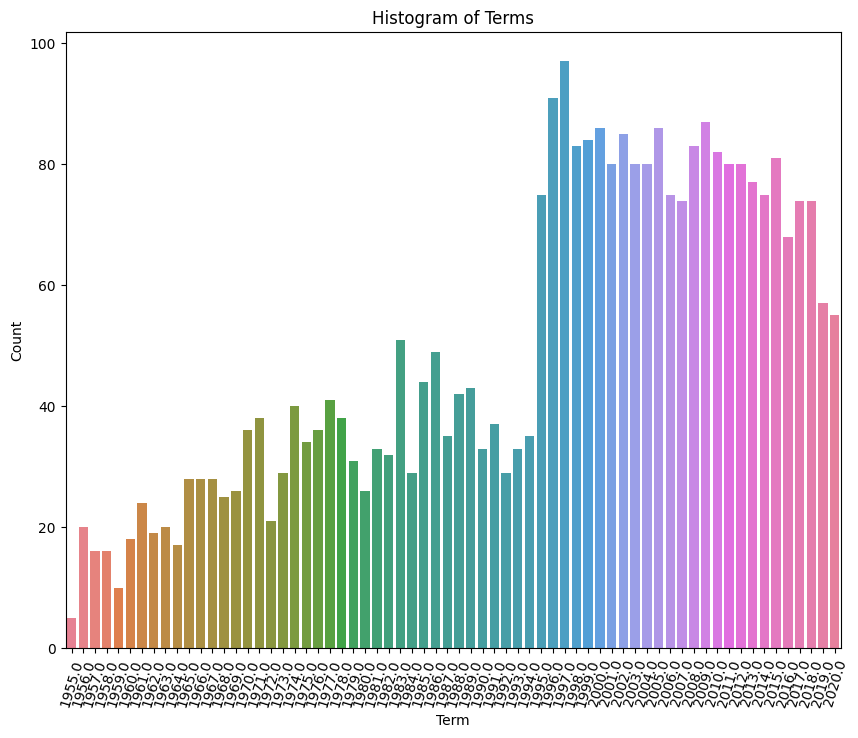

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(x='Term', y='Count', data=term_counts_pd, palette='husl')

plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Histogram of Terms')
plt.xticks(rotation=73)
plt.show()

Facts (len) distribution

In [117]:
factslen_counts = supreme.groupBy("facts_len").count()
factslen_counts = factslen_counts.collect()
factslen_counts_pd = pd.DataFrame(factslen_counts, columns=['Facts_len', 'Count'])

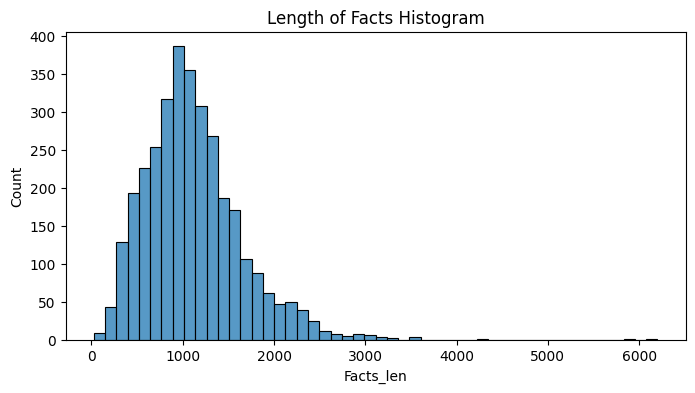

In [118]:
plt.figure(figsize=(8, 4))
sns.histplot(data=factslen_counts_pd, x='Facts_len', weights='Count', bins=50)

plt.xlabel('Facts_len')
plt.ylabel('Count')
plt.title('Length of Facts Histogram')
plt.show()

Distribution of Majority Vote

In [119]:
maj_vote_counts = supreme.groupBy("majority_vote").count()
maj_vote_counts = maj_vote_counts.collect()
maj_vote_counts_pd = pd.DataFrame(maj_vote_counts, columns=['Majority Vote', 'Count'])

<ipython-input-120-ee9dbfad2a28>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Majority Vote', y='Count', data=maj_vote_counts_pd, palette='husl')


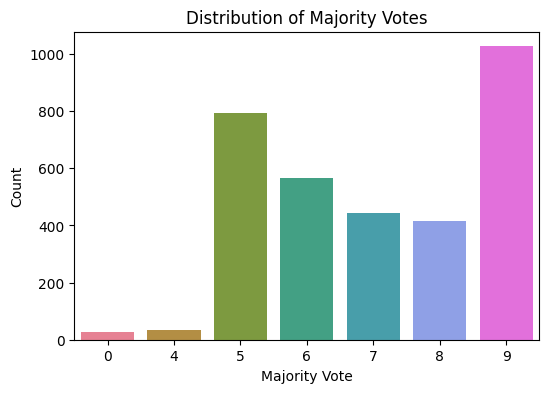

In [120]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Majority Vote', y='Count', data=maj_vote_counts_pd, palette='husl')

plt.xlabel('Majority Vote')
plt.ylabel('Count')
plt.title('Distribution of Majority Votes')
plt.show()

Distribution of Minority Vote

In [121]:
min_vote_counts = supreme.groupBy("minority_vote").count()
min_vote_counts = min_vote_counts.collect()
min_vote_counts_pd = pd.DataFrame(min_vote_counts, columns=['Minority Vote', 'Count'])

<ipython-input-122-368e7b8eaf8e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Minority Vote', y='Count', data=min_vote_counts_pd, palette='husl')


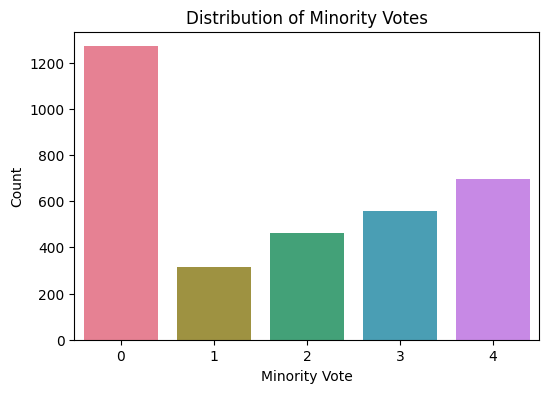

In [122]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Minority Vote', y='Count', data=min_vote_counts_pd, palette='husl')

plt.xlabel('Minority Vote')
plt.ylabel('Count')
plt.title('Distribution of Minority Votes')
plt.show()

Distribution of Decision Type

In [123]:
dec_type_counts = supreme.groupBy("decision_type").count()
dec_type_counts = dec_type_counts.collect()
dec_type_counts_pd = pd.DataFrame(dec_type_counts, columns=['Decision Type', 'Count'])

<ipython-input-124-ce4475c56b8a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Decision Type', y='Count', data=dec_type_counts_pd, palette='husl')


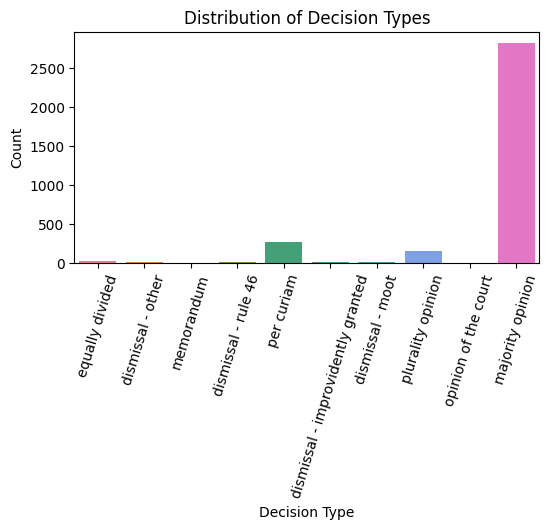

In [124]:
plt.figure(figsize=(6, 3))
sns.barplot(x='Decision Type', y='Count', data=dec_type_counts_pd, palette='husl')

plt.xlabel('Decision Type')
plt.ylabel('Count')
plt.title('Distribution of Decision Types')
plt.xticks(rotation=73)
plt.show()

Disposition Distribution

In [125]:
disp_counts = supreme.groupBy("disposition").count()
disp_counts = disp_counts.collect()
disp_counts_pd = pd.DataFrame(disp_counts, columns=['Disposition', 'Count'])

<ipython-input-126-45839b14f709>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disposition', y='Count', data=disp_counts_pd, palette='husl')


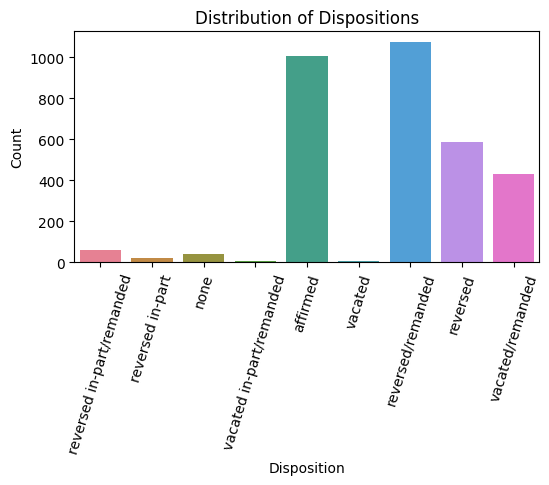

In [126]:
plt.figure(figsize=(6, 3))
sns.barplot(x='Disposition', y='Count', data=disp_counts_pd, palette='husl')

plt.xlabel('Disposition')
plt.ylabel('Count')
plt.title('Distribution of Dispositions')
plt.xticks(rotation=73)
plt.show()

Distribution of Issue Areas

In [127]:
issue_counts = supreme.groupBy("issue_area").count()
issue_counts = issue_counts.collect()
issue_counts_pd = pd.DataFrame(issue_counts, columns=['Issue Area', 'Count'])

<ipython-input-128-a9493370447f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Issue Area', y='Count', data=issue_counts_pd, palette='husl')


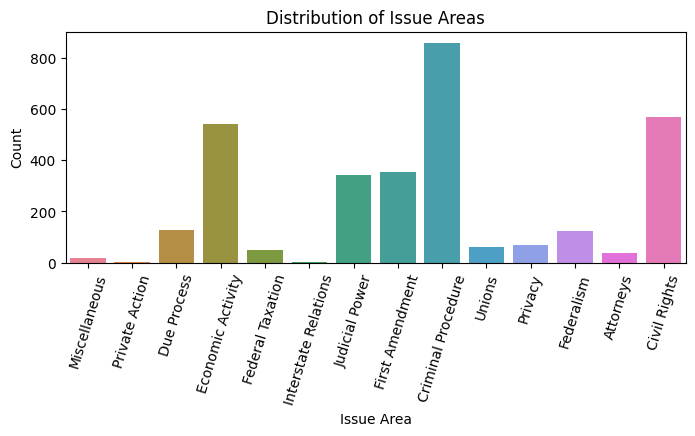

In [128]:
plt.figure(figsize=(8, 3))
sns.barplot(x='Issue Area', y='Count', data=issue_counts_pd, palette='husl')

plt.xlabel('Issue Area')
plt.ylabel('Count')
plt.title('Distribution of Issue Areas')
plt.xticks(rotation=73)
plt.show()

taking a look at the distribution of case outcomes throughout

In [129]:
judgement_counts = supreme.groupBy("first_party_winner").count()
judgement_counts = judgement_counts.collect()
judgement_counts_pd = pd.DataFrame(judgement_counts, columns=['Judgement', 'Count'])

<ipython-input-130-0f47c4bd6082>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Judgement', y='Count', data=judgement_counts_pd, palette='coolwarm')


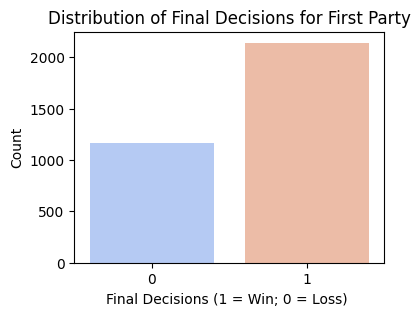

In [130]:
plt.figure(figsize=(4, 3))
sns.barplot(x='Judgement', y='Count', data=judgement_counts_pd, palette='coolwarm')

plt.xlabel('Final Decisions (1 = Win; 0 = Loss) ')
plt.ylabel('Count')
plt.title('Distribution of Final Decisions for First Party')
#plt.xticks(rotation=73)
plt.show()

## Range of values using Spark SQL for relevant features

In [131]:
supreme.createOrReplaceTempView("supreme")

In [132]:
# the range of values for the term column
spark.sql("SELECT MIN(term), MAX(term) FROM supreme").show()

+---------+---------+
|min(term)|max(term)|
+---------+---------+
|     1955|     2020|
+---------+---------+



In [133]:
# the range of values for the facts_len column
spark.sql("SELECT MIN(facts_len), MAX(facts_len) FROM supreme").show()

+--------------+--------------+
|min(facts_len)|max(facts_len)|
+--------------+--------------+
|            26|          6201|
+--------------+--------------+



In [134]:
# the range of values for the majority_vote column
spark.sql("SELECT MIN(majority_vote), MAX(majority_vote) FROM supreme").show()

+------------------+------------------+
|min(majority_vote)|max(majority_vote)|
+------------------+------------------+
|                 0|                 9|
+------------------+------------------+



In [135]:
# the range of values for the minority_vote column
spark.sql("SELECT MIN(minority_vote), MAX(minority_vote) FROM supreme").show()

+------------------+------------------+
|min(minority_vote)|max(minority_vote)|
+------------------+------------------+
|                 0|                 4|
+------------------+------------------+



In [136]:
# the range of values for the decision_type column (truncated/unreadable line is: "dismissal - improvidently granted")
# also taking note that there are 'null' categorical values for decision_type which don't need to be cleaned up later (confirmed when looking at dataframe during dropping rows section)
spark.sql("SELECT decision_type, count(*) as count FROM supreme GROUP BY decision_type ORDER BY count DESC").show()

+--------------------+-----+
|       decision_type|count|
+--------------------+-----+
|    majority opinion| 2829|
|          per curiam|  267|
|   plurality opinion|  153|
|     equally divided|   17|
| dismissal - rule 46|    9|
|   dismissal - other|    8|
|                NULL|    7|
|dismissal - impro...|    6|
|    dismissal - moot|    5|
|          memorandum|    1|
|opinion of the court|    1|
+--------------------+-----+



In [137]:
# the range of values for the disposition column (truncated columns: "reversed in-part/remanded" & "vacated in-part/remanded")
# also taking note here of the 'null' disposition categorical value ('none' is not to be confused with null, since it's possible not to have a disposition)
spark.sql("SELECT disposition, count(*) as count FROM supreme GROUP BY disposition ORDER by count DESC").show()

+--------------------+-----+
|         disposition|count|
+--------------------+-----+
|   reversed/remanded| 1073|
|            affirmed| 1007|
|            reversed|  585|
|    vacated/remanded|  430|
|                NULL|   72|
|reversed in-part/...|   61|
|                none|   41|
|    reversed in-part|   22|
|             vacated|    7|
|vacated in-part/r...|    5|
+--------------------+-----+



In [138]:
# the range of values for the issue_area column
# "NULL" issue_area
spark.sql("SELECT issue_area, count(*) as count FROM supreme GROUP BY issue_area ORDER by count DESC").show()

+--------------------+-----+
|          issue_area|count|
+--------------------+-----+
|  Criminal Procedure|  859|
|        Civil Rights|  568|
|   Economic Activity|  542|
|     First Amendment|  353|
|      Judicial Power|  342|
|                NULL|  142|
|         Due Process|  128|
|          Federalism|  125|
|             Privacy|   70|
|              Unions|   60|
|    Federal Taxation|   51|
|           Attorneys|   37|
|       Miscellaneous|   20|
|      Private Action|    4|
|Interstate Relations|    2|
+--------------------+-----+



In [139]:
# the range of values for the first_party_winner column (this is binary!)
spark.sql("SELECT MIN(first_party_winner), MAX(first_party_winner) FROM supreme").show()

+-----------------------+-----------------------+
|min(first_party_winner)|max(first_party_winner)|
+-----------------------+-----------------------+
|                      0|                      1|
+-----------------------+-----------------------+



## Most common words/n-grams found

In [140]:
from pyspark.sql.functions import regexp_replace

# replacing leading '<p>' and trailing '</p>' with an empty string--in addition to '\n' characters
supreme = supreme.withColumn("facts", regexp_replace("facts", "^<p>|</p>|\n$", ""))

Most Common Words in facts

In [141]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, explode

# tokenizing the text
tokenizer = Tokenizer(inputCol="facts", outputCol="words")
words_df = tokenizer.transform(supreme)

In [142]:
# Taking a look at words_df
# words_df.select('words').show(10, truncate=False)

In [143]:
# removing stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtered_df = remover.transform(words_df)

In [144]:
# checking against words_df for comparison
# filtered_df.select('filtered').show(10, truncate=False)

In [145]:
# make each word occupy its own row
word_per_row = filtered_df.withColumn("word", explode(col("filtered")))

In [146]:
# counting and sorting words
# finally, showing the top 20 most common words that are not stop words
wordCounts = word_per_row.groupBy("word").count().orderBy(col("count").desc())
wordCounts.show(n=20)

+--------+-----+
|    word|count|
+--------+-----+
|   court| 9315|
|district| 3872|
| appeals| 2419|
| federal| 2372|
|   state| 2231|
| circuit| 1928|
|    u.s.| 1691|
| supreme| 1568|
|    held| 1553|
|     act| 1474|
|   filed| 1355|
|        | 1099|
|   found| 1047|
|  argued| 1005|
|     new|  984|
|  united|  959|
|  denied|  954|
|  states|  916|
|    case|  904|
|violated|  903|
+--------+-----+
only showing top 20 rows



N-grams Found

In [147]:
from pyspark.ml.feature import NGram
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [148]:
# Creating n-grams
ngram = NGram(n=2, inputCol="filtered", outputCol="ngrams")
ngram_df = ngram.transform(filtered_df)

In [149]:
ngram_df.select('ngrams').show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [150]:
ngrams_column = ngram_df.select('ngrams')

# flattening
flattened_ngrams = ngrams_column.rdd.flatMap(lambda x: x).flatMap(lambda x: x)

In [151]:
# mapping n-grams to key-value pairs
ngram_key_value_pairs = flattened_ngrams.map(lambda x: (x, 1))

In [152]:
# taking a look..
#ngram_key_value_pairs.take(10)

In [153]:
# reducing by key
ngram_counts_reduced = ngram_key_value_pairs.reduceByKey(lambda x, y: x + y)

In [154]:
# just checking..
#ngram_counts_reduced.take(10)

In [155]:
# sorting by counts
ngram_counts_sorted = ngram_counts_reduced.sortBy(lambda x: -x[1])

# showing the top 10 ngrams
ngram_counts_sorted.take(10)

[('district court', 2691),
 ('court appeals', 2169),
 ('supreme court', 1216),
 ('u.s. court', 958),
 ('united states', 718),
 ('federal district', 529),
 ('court granted', 495),
 ('court held', 470),
 ('court denied', 425),
 ('ninth circuit', 398)]

# Section 2: Data Cleaning

## Dropping missing/incorrect data
- The initial dropping of all missing rows is necessary for model fitting
- The originally planned second dropping of some categories were due to null's appearing from viewing the data from spark.sql. From above, it was seen that NULL's existed. However, after looking more closely at the dataframe (below), it is evident that there are no NULL category types after the first initial dropping of rows and only that is needed. We shouldn't be confused by 'none' being in the 'disposition' column because it is possible for a case not to have a disposition.
- Additionally, we drop all missing rows in 'term' because one was found.

In [156]:
initial_count = supreme.count()
print(f"Initial row count: {initial_count}")

Initial row count: 3303


In [157]:
supreme = supreme.na.drop(subset=["facts", "facts_len", "majority_vote", "minority_vote", "first_party_winner", "decision_type", "disposition", "issue_area", "term"])

In [158]:
init_final_count = supreme.count()
drop_count = initial_count - init_final_count
print(f"Row count after dropping missing rows across relevant features: {init_final_count}")
print(f"Final rows dropped: {drop_count}")

Row count after dropping missing rows across relevant features: 3100
Final rows dropped: 203


In [159]:
supreme.select('decision_type').distinct().show()

+--------------------+
|       decision_type|
+--------------------+
|     equally divided|
|   dismissal - other|
|          per curiam|
|dismissal - impro...|
|    dismissal - moot|
|   plurality opinion|
|opinion of the court|
|    majority opinion|
+--------------------+



In [160]:
supreme.select('disposition').distinct().show()

+--------------------+
|         disposition|
+--------------------+
|reversed in-part/...|
|    reversed in-part|
|                none|
|vacated in-part/r...|
|            affirmed|
|             vacated|
|   reversed/remanded|
|            reversed|
|    vacated/remanded|
+--------------------+



In [161]:
supreme.select('issue_area').distinct().show()

+--------------------+
|          issue_area|
+--------------------+
|       Miscellaneous|
|      Private Action|
|         Due Process|
|   Economic Activity|
|    Federal Taxation|
|Interstate Relations|
|      Judicial Power|
|     First Amendment|
|  Criminal Procedure|
|              Unions|
|             Privacy|
|          Federalism|
|           Attorneys|
|        Civil Rights|
+--------------------+



## Renaming Columns
  - '_c0' column to 'index', for clarity

In [162]:
supreme = supreme.withColumnRenamed("_c0", "index")
supreme.show(5)

+-----+-----+--------------------+--------------------+-------+----+--------------------+--------------------+--------------------+---------+-------------+-------------+------------------+----------------+-----------------+---------------+
|index|   ID|                name|                href| docket|term|         first_party|        second_party|               facts|facts_len|majority_vote|minority_vote|first_party_winner|   decision_type|      disposition|     issue_area|
+-----+-----+--------------------+--------------------+-------+----+--------------------+--------------------+--------------------+---------+-------------+-------------+------------------+----------------+-----------------+---------------+
|    1|50613| Stanley v. Illinois|https://api.oyez....|70-5014|1971| Peter Stanley, Sr. |            Illinois|Joan Stanley had ...|      757|            5|            2|                 1|majority opinion|reversed/remanded|   Civil Rights|
|    2|50623|Giglio v. United ...|https:

## Fixing bad values in the Facts column
  - each row starts with '< p >' and ends with '< /p>' characters
  - each row also contains '\n' characters at the end of sentences sometimes, so they're attached to the final word (i.e., "...in the United States\n")
  - this was all done above, to facilitate more appropriate results from finding n-grams and most common words. The code is here for documentation and for verifying the changes:

In [163]:
from pyspark.sql.functions import regexp_replace

#supreme = supreme.withColumn("facts", regexp_replace("facts", "^<p>|</p>$", ""))

# verifying changes
supreme.select("facts").show(5)

+--------------------+
|               facts|
+--------------------+
|Joan Stanley had ...|
|John Giglio was c...|
|The Idaho Probate...|
|Miller, after con...|
|Ernest E. Mandel ...|
+--------------------+
only showing top 5 rows



## Further Facts Pre-Processing:
  - using regex, we replace any of the standard characters that aren't letters, numbers, or whitespace, as empty strings--removing them.
  - next, convert to lowercase

In [164]:
from pyspark.sql.functions import lower

supreme = supreme.withColumn("facts_cleaned", regexp_replace("facts", "[^a-zA-Z0-9\\s]", ""))
supreme = supreme.withColumn("facts_cleaned", lower(col("facts_cleaned")))

supreme.select("facts_cleaned").show(5, truncate=True)

+--------------------+
|       facts_cleaned|
+--------------------+
|joan stanley had ...|
|john giglio was c...|
|the idaho probate...|
|miller after cond...|
|ernest e mandel w...|
+--------------------+
only showing top 5 rows



# Section 3: Data Transformation

## UDF: Sentiment Analysis of Facts
  - VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, or more generally, in short pieces of text. It uses a carefully curated set of known sentiment-laden words, along with grammatical and syntactical rules, to gauge the sentiment of texts.
  - VADER provides a compound score that ranges from -1 (most negative) to +1 (most positive), which represents the overall sentiment of a piece of text
  - a new feature: 'facts_sentiment' will indicate each cases' facts' overall sentiment.
    - Positive, Neutral, or Negative
    - Score: (-1 - 1)
  - Explanation for adding this column is above in the "Relevant Features" section. Long story short, this feature can provide a unique perspective on the emotional context of each case.

In [165]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [166]:
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, FloatType

sia = SentimentIntensityAnalyzer()

In [167]:
def analyze_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive', compound
    elif compound <= -0.05:
        return 'negative', compound
    else:
        return 'neutral', compound

schema = StructType([
    StructField("label", StringType(), False),
    StructField("score", FloatType(), False)
])

Applying the UDF, creating a new column 'facts_sentiment'

In [168]:
sentiment_vader_udf = udf(analyze_sentiment_vader, schema)

supreme = supreme.withColumn("facts_sentiment", sentiment_vader_udf("facts_cleaned"))

Adding new columns to individualize sentiment labels and scores

In [169]:
supreme = supreme.withColumn("sentiment_label", col("facts_sentiment.label"))
supreme = supreme.withColumn("sentiment_score", col("facts_sentiment.score"))

Taking a look..

In [170]:
supreme.select("facts_cleaned", "facts_sentiment", "sentiment_label", "sentiment_score").show(5, truncate=True)

+--------------------+-------------------+---------------+---------------+
|       facts_cleaned|    facts_sentiment|sentiment_label|sentiment_score|
+--------------------+-------------------+---------------+---------------+
|joan stanley had ...| {negative, -0.752}|       negative|         -0.752|
|john giglio was c...|{negative, -0.9223}|       negative|        -0.9223|
|the idaho probate...|{negative, -0.6486}|       negative|        -0.6486|
|miller after cond...|{negative, -0.8591}|       negative|        -0.8591|
|ernest e mandel w...| {positive, 0.9834}|       positive|         0.9834|
+--------------------+-------------------+---------------+---------------+
only showing top 5 rows



### Distribution of Sentiment Labels

In [171]:
# extracting values
filtered_df = supreme.filter(col("sentiment_label").isin(['negative', 'neutral', 'positive']))

# collecting the values of the sentiment_label column into a list
sentiment_labels = [row['sentiment_label'] for row in filtered_df.select("sentiment_label").collect()]

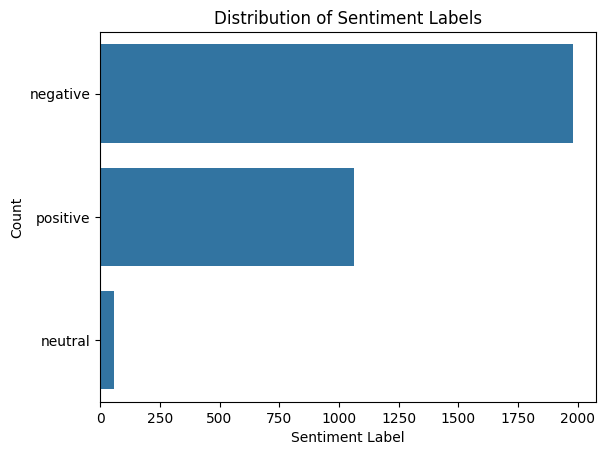

In [172]:
sns.countplot(sentiment_labels)
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

## Creating vectors for relevant features and one-hot encoding categorical variables


In [173]:
supreme.printSchema()

root
 |-- index: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- href: string (nullable = true)
 |-- docket: string (nullable = true)
 |-- term: integer (nullable = true)
 |-- first_party: string (nullable = true)
 |-- second_party: string (nullable = true)
 |-- facts: string (nullable = true)
 |-- facts_len: integer (nullable = true)
 |-- majority_vote: integer (nullable = true)
 |-- minority_vote: integer (nullable = true)
 |-- first_party_winner: integer (nullable = false)
 |-- decision_type: string (nullable = true)
 |-- disposition: string (nullable = true)
 |-- issue_area: string (nullable = true)
 |-- facts_cleaned: string (nullable = true)
 |-- facts_sentiment: struct (nullable = true)
 |    |-- label: string (nullable = false)
 |    |-- score: float (nullable = false)
 |-- sentiment_label: string (nullable = true)
 |-- sentiment_score: float (nullable = true)



In [174]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_index")
    for c in ["decision_type", "disposition", "issue_area", "sentiment_label"]
]

In [175]:
from pyspark.ml.feature import OneHotEncoder

encoders = [
    OneHotEncoder(inputCol=f"{c}_index", outputCol=f"{c}_vec")
    for c in ["decision_type", "disposition", "issue_area", "sentiment_label"]
]

In [176]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[
    "facts_len",
    "majority_vote",
    "minority_vote",
    "sentiment_score",
    "decision_type_vec",
    "disposition_vec",
    "issue_area_vec",
    "sentiment_label_vec"
], outputCol="features")

In [177]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders + [assembler])

# fitting the pipeline
supreme_xformed = pipeline.fit(supreme).transform(supreme)

## Train/Test Data Splitting
  - 80% / 20%

In [178]:
train, test = supreme_xformed.randomSplit([0.8, 0.2], seed=43)

# Section 4: Data Analysis


## Binary Classification Prediction with Logistic Regression

Model Training
- 'first_party_winner' should be numeric and binary, which we did previously.

In [179]:
from pyspark.ml.classification import LogisticRegression

# initializing model
lr = LogisticRegression(featuresCol="features", labelCol="first_party_winner")

# fitting model
lr_model = lr.fit(train)

Use the model to make predictions on the test set

In [180]:
predictions = lr_model.transform(test)

predictions.select("prediction", "first_party_winner", "features").show(5)

+----------+------------------+--------------------+
|prediction|first_party_winner|            features|
+----------+------------------+--------------------+
|       1.0|                 1|(34,[0,1,2,3,4,11...|
|       0.0|                 0|(34,[0,1,2,3,4,12...|
|       1.0|                 1|(34,[0,1,3,4,11,2...|
|       1.0|                 1|(34,[0,1,2,3,4,14...|
|       1.0|                 1|(34,[0,1,2,6,11,2...|
+----------+------------------+--------------------+
only showing top 5 rows



Computing AUC-ROC

In [181]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# initialize the evaluator for computing the AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="first_party_winner", metricName="areaUnderROC")

# computing auc
roc_auc = evaluator.evaluate(predictions)

print(f"Area under the ROC curve: {roc_auc}")

Area under the ROC curve: 0.973419054064213


Computing Precision, Recall, and F1-Score

In [182]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# For Precision, Recall, F1-Score
multiEvaluator = MulticlassClassificationEvaluator(labelCol="first_party_winner", predictionCol="prediction")
precision = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "precisionByLabel"})
recall = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "recallByLabel"})
f1 = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "f1"})
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1)

Precision = 0.9627659574468085
Recall = 0.9141414141414141
F1 Score = 0.9597939733685754


Computing Accuracy

In [184]:
accuracyEvaluator = MulticlassClassificationEvaluator(labelCol="first_party_winner", predictionCol="prediction", metricName="accuracy")

accuracy = accuracyEvaluator.evaluate(predictions)

print("Accuracy = %s" % accuracy)

Accuracy = 0.9600665557404326


### Evaluation of Logistic Regression Model

    Area Under the ROC Curve (AUC-ROC): 0.987

The AUC-ROC is a comprehensive measure of the model's ability to distinguish between the classes. A score close to 1 indicates a high level of model performance. With an AUC-ROC of approximately 0.987, the model demonstrates an excellent capacity to differentiate between the positive and negative classes, suggesting that it can reliably identify the likelihood of 'first_party_winner' with high accuracy.

    Precision: 0.959

Precision measures the proportion of correctly predicted positive observations to the total predicted positives. A precision of 0.959 means that about 96% of the cases predicted as 'winners' by the model were indeed winners, indicating a high reliability in the model's positive predictions.

    Recall: 0.949

Recall (or sensitivity) assesses the model's ability to find all the relevant cases within a dataset. The recall of 0.949 implies that the model successfully identifies 95% of all actual winners as such. This high recall rate is critical for scenarios where missing a positive case (e.g., predicting a winner as a loser) could have significant consequences.

    F1 Score: 0.970

The F1 Score is the harmonic mean of Precision and Recall, providing a single metric to assess the balance between them. An F1 Score of 0.970 suggests that the model achieves an excellent balance between Precision and Recall, making it highly effective for our binary classification task.

## Interesting Views

Hypotheses:
  - `H1`: The number of cases brought to the Supreme Court has significantly fluctuated over terms, potentially reflecting changes in societal issues, legal challenges, or court dynamics.
  - `H2`: Certain issue areas have significantly higher win rates, suggesting that the Court may exhibit systematic biases or preferences towards specific legal domains
  - `H3`: The type of court decision (e.g., majority opinion, per curiam) affects the win rate for the first party, with some decision types being more favorable than others.
  - `H4`: The length of the case facts correlates with the outcome, where longer facts could indicate more comprehensive arguments that might sway the Court's decision in favor of the presenting party.

In [86]:
supreme.createOrReplaceTempView("supreme_data")

### H1: Cases Per Term

- This view aggregates the total number of Supreme Court cases per term, offering a clear picture of the caseload over time. It helps in identifying trends such as increases or decreases in the volume of cases, which might reflect historical, legal, or societal changes.

In [87]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW CasesPerTerm AS
SELECT term, COUNT(*) as case_count
FROM supreme_data
GROUP BY term
ORDER BY term
""")

spark.sql("SELECT * FROM CasesPerTerm").show()

+----+----------+
|term|case_count|
+----+----------+
|1955|         5|
|1956|        18|
|1957|        15|
|1958|        15|
|1959|         8|
|1960|        16|
|1961|        22|
|1962|        19|
|1963|        19|
|1964|        16|
|1965|        26|
|1966|        28|
|1967|        25|
|1968|        23|
|1969|        22|
|1970|        34|
|1971|        35|
|1972|        21|
|1973|        29|
|1974|        40|
+----+----------+
only showing top 20 rows



### H2: Win Rate by Issue Area

- By calculating the win rate for the first party across different issue areas, this view sheds light on which legal domains see a higher success rate for plaintiffs. This insight can help in understanding if certain areas of law are more favorable to the first party.

In [88]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW WinRate AS
SELECT issue_area, AVG(first_party_winner) as win_rate
FROM supreme_data
GROUP BY issue_area
ORDER BY win_rate DESC
""")

spark.sql("SELECT * FROM WinRate").show()

+--------------------+-------------------+
|          issue_area|           win_rate|
+--------------------+-------------------+
|           Attorneys| 0.7297297297297297|
|  Criminal Procedure| 0.6989374262101535|
|             Privacy| 0.6956521739130435|
|      Judicial Power| 0.6828478964401294|
|         Due Process| 0.6692913385826772|
|     First Amendment| 0.6657142857142857|
|        Civil Rights| 0.6654804270462633|
|   Economic Activity| 0.6512059369202227|
|              Unions| 0.6101694915254238|
|    Federal Taxation| 0.5686274509803921|
|          Federalism|              0.552|
|      Private Action|                0.5|
|Interstate Relations|                0.5|
|       Miscellaneous|0.47368421052631576|
+--------------------+-------------------+



### Majority vs. Minority Vote Analysis

- This view explores how the configuration of majority and minority votes within the court correlates with the outcome for the first party. It provides a unique angle to assess how unanimous or divided court decisions impact case outcomes.

In [89]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW MajorityMinority AS
SELECT majority_vote, minority_vote, AVG(first_party_winner) as average_win
FROM supreme_data
GROUP BY majority_vote, minority_vote
ORDER BY average_win DESC
""")

spark.sql("SELECT * FROM MajorityMinority").show()

+-------------+-------------+------------------+
|majority_vote|minority_vote|       average_win|
+-------------+-------------+------------------+
|            6|            0|               1.0|
|            7|            1|0.7846153846153846|
|            6|            1|              0.75|
|            5|            3|0.7176470588235294|
|            7|            2|0.7113702623906706|
|            8|            1|0.7109004739336493|
|            9|            0|0.7079918032786885|
|            5|            2|            0.6875|
|            8|            0|0.6802325581395349|
|            6|            3|0.6565420560747663|
|            5|            4|0.5840978593272171|
|            6|            2|0.5813953488372093|
|            4|            3|               0.5|
|            7|            0|               0.5|
|            4|            2|0.3333333333333333|
|            4|            4|               0.0|
+-------------+-------------+------------------+



### Sentiment Analysis of Case Facts

- This view categorizes cases based on the sentiment (positive, negative, neutral) of their facts and compares the win rates among these categories. It aims to uncover whether the emotional tone of case descriptions correlates with judicial outcomes.

In [90]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW SentimentAnalysis AS
SELECT sentiment_label, AVG(first_party_winner) as win_rate
FROM supreme_data
GROUP BY sentiment_label
ORDER BY win_rate DESC
""")

spark.sql("SELECT * FROM SentimentAnalysis").show()

+---------------+------------------+
|sentiment_label|          win_rate|
+---------------+------------------+
|       negative|0.6779575328614762|
|       positive| 0.651928504233302|
|        neutral| 0.559322033898305|
+---------------+------------------+



### H3: Decision Type Impact on Cases

- Investigating the influence of different decision types (e.g., majority opinion, per curiam) on case outcomes, this view can reveal whether some types of decisions are more likely to result in a win for the first party, offering insights into the judicial process and its nuances.

In [91]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW DecisionTypeImpact AS
SELECT decision_type, AVG(first_party_winner) as win_rate
FROM supreme_data
GROUP BY decision_type
ORDER BY win_rate DESC
""")

spark.sql("SELECT * FROM DecisionTypeImpact").show()

+--------------------+------------------+
|       decision_type|          win_rate|
+--------------------+------------------+
|    dismissal - moot|               1.0|
|opinion of the court|               1.0|
|          per curiam|0.8873239436619719|
|    majority opinion|0.6595666544252663|
|   plurality opinion|0.5517241379310345|
|     equally divided|               0.0|
|   dismissal - other|               0.0|
|dismissal - impro...|               0.0|
+--------------------+------------------+



### Term Analysis for Sentiment Label Distribution

- By examining the distribution of sentiment labels (positive, negative, neutral) across different terms, this view helps in understanding how the emotional tone of case facts changes over time, possibly reflecting shifts in societal attitudes or legal priorities.

In [92]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW TermSentimentDistribution AS
SELECT term, sentiment_label, COUNT(*) as cases_count
FROM supreme_data
GROUP BY term, sentiment_label
ORDER BY term, sentiment_label
""")

spark.sql("SELECT * FROM TermSentimentDistribution").show()

+----+---------------+-----------+
|term|sentiment_label|cases_count|
+----+---------------+-----------+
|1955|       negative|          3|
|1955|       positive|          2|
|1956|       negative|         11|
|1956|        neutral|          3|
|1956|       positive|          4|
|1957|       negative|          9|
|1957|        neutral|          1|
|1957|       positive|          5|
|1958|       negative|         11|
|1958|       positive|          4|
|1959|       negative|          4|
|1959|       positive|          4|
|1960|       negative|          9|
|1960|       positive|          7|
|1961|       negative|         13|
|1961|       positive|          9|
|1962|       negative|         11|
|1962|        neutral|          1|
|1962|       positive|          7|
|1963|       negative|         11|
+----+---------------+-----------+
only showing top 20 rows



### H4: Average Facts Length by Win Status

- This view compares the average length of the case facts for won vs. lost cases, aiming to identify if there's a link between the detail or complexity of a case's description and its likelihood of winning, suggesting how the depth of case presentation might influence outcomes.

In [93]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW AvgFactsLengthByWinStatus AS
SELECT first_party_winner, AVG(facts_len) as avg_facts_length
FROM supreme_data
GROUP BY first_party_winner
ORDER BY first_party_winner
""")

spark.sql("SELECT * FROM AvgFactsLengthByWinStatus").show()

+------------------+------------------+
|first_party_winner|  avg_facts_length|
+------------------+------------------+
|                 0| 1121.216844143272|
|                 1|1126.9709724238026|
+------------------+------------------+



### Majority Vote Impact on Sentiment Score

- Analyzing the relationship between the majority vote count and the average sentiment score of case facts, this view investigates whether cases with stronger consensus among justices are associated with particular sentiment scores, hinting at the emotional undertones of more clear-cut legal decisions.

In [94]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW MajorityVoteSentiment AS
SELECT majority_vote, AVG(sentiment_score) as avg_sentiment_score
FROM supreme_data
GROUP BY majority_vote
ORDER BY majority_vote
""")

spark.sql("SELECT * FROM MajorityVoteSentiment").show()

+-------------+--------------------+
|majority_vote| avg_sentiment_score|
+-------------+--------------------+
|            4|-0.05564286187291145|
|            5|-0.26761165605919646|
|            6| -0.2398240534581198|
|            7|-0.29737697574634886|
|            8| -0.2388075730391333|
|            9| -0.2511012293703732|
+-------------+--------------------+



### Disposition Impact on Case Outcome

- Exploring how different dispositions (e.g., reversed, affirmed) affect the win rate of the first party, this view offers insights into how the final ruling's nature correlates with the success of the appealing party, providing a deeper understanding of judicial patterns.

In [95]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW DispositionImpact AS
SELECT disposition, AVG(first_party_winner) as win_rate
FROM supreme_data
GROUP BY disposition
ORDER BY win_rate DESC
""")

spark.sql("SELECT * FROM DispositionImpact").show()

+--------------------+--------------------+
|         disposition|            win_rate|
+--------------------+--------------------+
|             vacated|                 1.0|
|   reversed/remanded|  0.9904761904761905|
|            reversed|  0.9893428063943162|
|    vacated/remanded|  0.9258373205741627|
|vacated in-part/r...|                 0.8|
|reversed in-part/...|  0.7049180327868853|
|    reversed in-part|   0.631578947368421|
|                none|  0.3076923076923077|
|            affirmed|0.014507772020725389|
+--------------------+--------------------+



### Cases Won by Term and Issue Area

- This view breaks down the success rate of cases by term and issue area, enabling a granular analysis of how the likelihood of winning varies across different legal domains and periods. It can reveal trends and shifts in judicial outcomes related to specific areas of law over time.

In [96]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW CasesWonByTermIssueArea AS
SELECT term, issue_area, SUM(first_party_winner) as cases_won, COUNT(*) as total_cases
FROM supreme_data
GROUP BY term, issue_area
ORDER BY term, issue_area
""")

spark.sql("SELECT * FROM CasesWonByTermIssueArea").show()

+----+------------------+---------+-----------+
|term|        issue_area|cases_won|total_cases|
+----+------------------+---------+-----------+
|1955|      Civil Rights|        2|          2|
|1955|   First Amendment|        2|          3|
|1956|Criminal Procedure|        5|          5|
|1956| Economic Activity|        4|          5|
|1956|   First Amendment|        3|          5|
|1956|    Judicial Power|        0|          2|
|1956|            Unions|        1|          1|
|1957|Criminal Procedure|        1|          4|
|1957| Economic Activity|        2|          4|
|1957|        Federalism|        0|          1|
|1957|   First Amendment|        5|          6|
|1958|      Civil Rights|        1|          1|
|1958|Criminal Procedure|        2|          5|
|1958| Economic Activity|        3|          4|
|1958|        Federalism|        1|          2|
|1958|   First Amendment|        0|          2|
|1958|    Judicial Power|        1|          1|
|1959|      Civil Rights|        0|     

## Experiment: How well can a model predict the outcome based on "just" the facts?

Overview:

Trained a logistic regression model to predict Supreme Court case outcomes based on case descriptions (facts) and legal domains (issue_area).
Method

    Features: Textual facts of cases and their issue_area.
    Model: Logistic regression, with preprocessing for text vectorization and categorical encoding.

Results

The model was evaluated for accuracy and showed promising predictive performance. However, based on the scoring in comparison with the previous model, it's evident that the model needs much more features to increase its prediction accuracy and that there are a lot more potential factors of influence other than just "the facts" and their issue areas.
Case Study

Applied the model to predict outcomes for hypothetical cases in "Economic Activity" and "Unions" domains, showcasing its practical utility.

In [185]:
from pyspark.ml.feature import HashingTF, IndexToString

# tokenizing the 'facts' text
tokenizer = Tokenizer(inputCol="facts", outputCol="words")

# feature hashing on the tokenized 'facts'
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features_facts", numFeatures=1000)

# converting 'issue_area' into indexed categories
issue_area_indexer = StringIndexer(inputCol="issue_area", outputCol="issue_area_index")

# one-hot encoding the indexed 'issue_area'
encoder = OneHotEncoder(inputCol="issue_area_index", outputCol="features_issue_area")

# assembling 'features_facts' and 'features_issue_area' into a single feature vector
assembler = VectorAssembler(inputCols=["features_facts", "features_issue_area"], outputCol="features")

# logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="first_party_winner")

# pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, issue_area_indexer, encoder, assembler, lr])

In [186]:
(train, test) = supreme.randomSplit([0.8, 0.2], seed=1234)

In [187]:
# fitting pipeline
model = pipeline.fit(train)

# making predictions
predictions = model.transform(test)

# evaluation using AUC-ROC

evaluator = BinaryClassificationEvaluator(labelCol="first_party_winner", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under the ROC curve: {roc_auc}")

Area under the ROC curve: 0.5811620635747785


In [188]:
# For Precision, Recall, F1-Score
multiEvaluator = MulticlassClassificationEvaluator(labelCol="first_party_winner", predictionCol="prediction")
precision = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "precisionByLabel"})
recall = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "recallByLabel"})
f1 = multiEvaluator.evaluate(predictions, {multiEvaluator.metricName: "f1"})
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1)

Precision = 0.4369369369369369
Recall = 0.4801980198019802
F1 Score = 0.6087910999893105


In [191]:
# For Accuracy
accuracyEvaluator = MulticlassClassificationEvaluator(labelCol="first_party_winner", predictionCol="prediction", metricName="accuracy")

accuracy = accuracyEvaluator.evaluate(predictions)

print("Accuracy = %s" % accuracy)

Accuracy = 0.6048109965635738


In [101]:
# example new cases (created by LLM's)
new_cases = spark.createDataFrame([
    ("A group of small business owners files a lawsuit against a new federal regulation that imposes significant restrictions on online advertising practices. They argue that the regulation unfairly targets smaller enterprises, placing them at a competitive disadvantage against larger corporations. The plaintiffs claim these restrictions violate their rights to engage in free commerce and free speech, as guaranteed by the Constitution.", "Economic Activity"),
    ("A public sector workers' union challenges a state law that prohibits union dues from being automatically deducted from workers' paychecks. The union contends that this law infringes on their rights to organize and collectively bargain, asserting that it significantly hampers their ability to support and represent their members effectively. They argue this law is a direct violation of the First Amendment rights of association and petition.", "Unions")
], ["facts", "issue_area"])

# making predictions on the new cases
new_predictions = model.transform(new_cases)

new_predictions.select("facts", "issue_area", "prediction", "probability").show(truncate=True)

+--------------------+-----------------+----------+--------------------+
|               facts|       issue_area|prediction|         probability|
+--------------------+-----------------+----------+--------------------+
|A group of small ...|Economic Activity|       1.0|[0.00330346135335...|
|A public sector w...|           Unions|       0.0|[0.66769277895179...|
+--------------------+-----------------+----------+--------------------+



### Evaluation

Case 1: Economic Activity

Facts Summary: A lawsuit challenges federal regulations on online advertising, arguing they unfairly target small businesses.

    Issue Area: Economic Activity
    Prediction: Win (1.0)
    Probability: [0.0033, 0.9967]

The model predicts that the first party (presumably the group of small business owners) will win the case with a very high confidence (probability of winning is approximately 99.67%). This suggests that, based on the model's learning from historical data, cases similar to this scenario within the "Economic Activity" domain are likely to result in a victory for the challenger.


Case 2: Unions

Facts Summary: A union challenges a state law prohibiting automatic union dues deductions from paychecks.

    Issue Area: Unions
    Prediction: Loss (0.0)
    Probability: [0.6677, 0.3323]

For this case, the model predicts a loss for the union challenging the state law, with a moderate level of confidence (probability of losing is approximately 66.77%). This indicates that, according to the model's training on past cases, such challenges within the "Unions" issue area tend to not favor the party challenging the state laws.